## Problem Statement

The **Traveling Salesman Problem (TSP)** is a classic optimization problem in the field of computer science and operations research. The challenge involves a salesman who must find the shortest possible route that visits a set of cities exactly once and returns to the origin city. This problem is notoriously difficult as the number of possible routes increases factorially with the number of cities, making an exhaustive search for the optimal solution computationally infeasible for large numbers of cities. Hence, heuristic and approximation algorithms are employed to find satisfactory solutions within a reasonable time frame.

One effective heuristic for tackling the TSP is the Genetic Algorithm (GA), an evolutionary algorithm inspired by the process of natural selection. A GA employs a population of individual solutions (chromosome), represented as strings or sequences that correspond to the order in which cities are visited.

When using GAs for curve fitting, we must define:

- A **fitness function** to evaluate how well a polynomial fits the data.
- A **selection mechanism** to choose which individuals to mate.
- **Crossover and mutation operators** to generate new offspring.
- A **population size** and a set of potential solution candidates.

By fine-tuning parameters and employing a GA, one can arrive at a very efficient and near-optimal solution to the TSP. Despite not always guaranteeing the best possible solution, GAs have proven to be a robust approach for finding high-quality solutions to the TSP, particularly when the problem size becomes large.

In [482]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

## Data Visualization

The next part requires a certain format for the test data. Our data is stored in the TSP-Tests directory, with files named from gr229 to pr1002. The first 6-7 lines is a summary of the overall data including its name, type of data, dimention or number of cities present in the file etc. The coordication of the cities are listed under the line 'NODE_COORD_SECTION'. each line consis of 3 numbers seperated by space, first is the ID of the city numbering form 1 to the number of cities present, second is the x coordinate of the city and third is the y coordinate of the city.

The next part requires a certain format for the test data. This dataset is stored in the 'TSP-Tests' folder with names 'gr229.tsp' and 'pr1002.tsp'. The initial 6 to 7 lines provide an overview of the dataset, consisting of the dataset's name, category, and the dimensions, (the total count of cities contained in each file), etc. Under the section labeled 'NODE_COORD_SECTION' are the cities' coordinates. Here, lines are formatted with three numerals seperated by spaces. The first number is the city's identifier, ascending from 1 to the total number of cities. The second and third numbers represent the city's x and y coordinates, respectively.

In [501]:
pop_size = 200
file_path = './TSP-Tests/gr229.tsp'
x = []
y = []
n = 0

with open(file_path, 'r') as file:
    # Iterate through each line in the file
    for line in file:
        # Split the line into a list of numbers (as strings)
        parts = line.split()

        if parts[0].isdigit():
            x.append(float(parts[1]))
            y.append(float(parts[2]))

n = len(x)

Data shape:  229 229


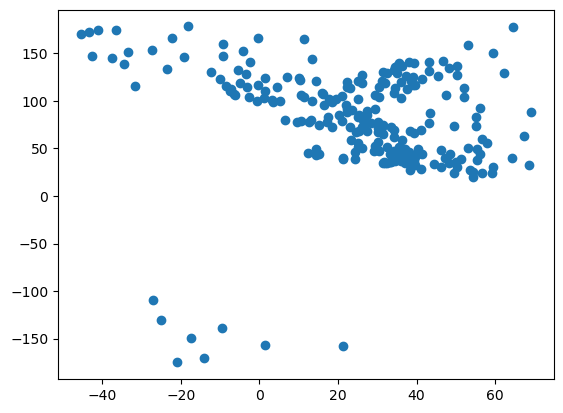

In [502]:
print('Data shape: ', len(x), len(y))
plt.scatter(x, y)
plt.show()

Data shape:  1002 1002


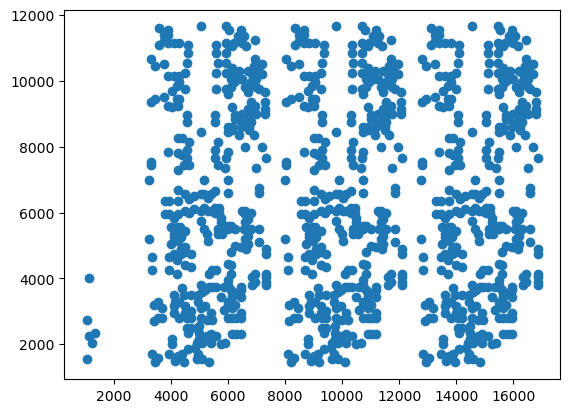

In [485]:
print('Data shape: ', len(x), len(y))
plt.scatter(x, y)
plt.show()

## Genetic Algorithm Operators

### Calculating Distance

In the TSP, **Euclidean distance** plays a pivotal role in calculating the shortest possible route that visits each city exactly once and returns to the starting point. Specifically, Euclidean distance measures the straight-line distance between two points in a 2D or 3D space. 

Given a set of cities, each with its own coordinates (x, y) on a plane, the Euclidean distance between any two cities A and B with coordinates $ (x_A, y_A) $ and $ (x_B, y_B) $ respectively, is calculated using the Pythagorean theorem:

$$ \text{Euclidean Distance} = \sqrt{(x_B-x_A)^2 + (y_B-y_A)^2} $$

When a genetic algorithm or any other heuristic method is used to solve TSP, this distance calculation is used to evaluate the 'fitness' of a route. The sum of the Euclidean distances between each pair of consecutive cities on the route, plus the return distance to the starting city, gives the total distance of the route. The goal is to minimize this total distance. 

The equation for calculating distances is central to the algorithm’s performance. It is utilized extensively – applied during the initial setup of chromosomes as well as during the crossover of parent chromosomes across numerous iterations. To minimize runtime, precalculating all pairwise city distances and storing them in a matrix (here referred to as `adj_mat`), seems to be a good idea. This allows the algorithm to quickly reference the distances without recalculating them each time. However, this approach can be memory-intensive when dealing with a large number of cities, potentially making it impractical. For our dataset, though, this should not pose any issues.

In [503]:
def eucDist(n1, n2):
    return round(math.sqrt(pow(x[n1] - x[n2], 2) + pow(y[n1] - y[n2], 2)), 3)

adj_mat = [[eucDist(i, j) for j in range(n)] for i in range(n)]

### Chromosome

The Chromosome class encapsulates the representation of a population’s chromosomes, handling their individual modifications. A chromosome serves as a potential solution to the problem, articulated as a sequence of numbers where each number corresponds to a city. The sequence’s arrangement specifies the visitation order, with the city at position $i+1$ being visited immediately after the city at position $i$, and the first city visited again after the last one in the list. This class uses global variables x (x-coordinates of the cities), y (y-coordinates), n (total number of cities), and adj_mat (precomputed distance matrix that stores the pairwise distances between cities) and it includes the following methods:

- `__init__()`: This method is called when a new class instance is created. It stores the input list in the `self.chr` attribute and calculates the list's fitness level using the `fitFunc()` method.

- `fitFunc()`: The fitness function, sometimes called a cost or loss function, assesses the appropriateness or “fitness” of a candidate solution among a population, guiding the pursuit of the optima. It operates by traversing the list and cumulatively adding up the distances between consecutive elements, the $i^{th}$ and $i+1^{th}$, as retrieved from the distance matrix adj_mat.
    
- `mutateScramble()`: In scramble mutation, a subset of genes is chosen randomly from the chromosome (indexes indicated by `m1` and `m2`). The values in this subset are then scrambled or shuffled randomly. This means that within this selected segment, the genes are rearranged in a random order. It serves to maintain diversity in the population and possibly lead to new solutions. The rest of the chromosome remains unaltered. Scramble mutation doesn't introduce new genes into the chromosome; instead, it rearranges existing genes in a way that could potentially uncover new and beneficial gene sequences. (Further information on `mutationScramble()` is provided is provided later in the code.)

- `mutateSwap()`**: During mutation process by `mutatationSwap()`, this function is involved in altering the genetic structure by switching the values of two randomly selected points on the chromosome. However, this function is not used throughout the algorithm since `mutationScramble()` has been shown to yield superior results. (Further information on `mutationSwap()` is provided later on.)

- `mutateInsert()`**: Insert mutation selects a single gene and moves it to a different position within the chromosome, effectively inserting it into the sequence at this new point and shifting the other genes to accommodate the change. Insert mutation can be particularly useful when the order of genes is important to the quality of the solution, such as in sequencing or routing problems. However, this function is not used throughout the algorithm since `mutationScramble()` has been shown to yield superior results. (Further information on `mutationInsert()` is provided later on.)

In [487]:
class Chromosome:
    global x, y, n, adj_mat
    def __init__(self, chr):
        self.chr = chr
        self.fitness = self.fitnessFunc(self.chr)
    
    def fitnessFunc(self, chr):
        tmp = 0
        for i in range(len(chr) - 1):
            tmp += adj_mat[chr[i]][chr[i + 1]]
        tmp += adj_mat[chr[0]][chr[n - 1]] #Adding the distance between the first and the last cities
        return tmp
    
    def mutateSwap(self, m1, m2):
        tmp = self.chr[m1]
        self.chr[m1] = self.chr[m2]
        self.chr[m2] = tmp
        self.fitness = self.fitnessFunc(self.chr)
        return
    
    def mutateScramble(self, m1, m2):
        tmp = self.chr[m1:m2]
        random.shuffle(tmp)
        self.chr[m1:m2] = tmp
        self.fitness = self.fitnessFunc(self.chr)
        return
    
    def mutateInsert(self, m1, m2):
        self.chr = self.chr[:m1] + [self.chr[m2]] + self.chr[m1: m2] + self.chr[m2 + 1:]
        self.fitness = self.fitnessFunc(self.chr)
        return

### Initialization (Population Generation)

When initiating a genetic algorithm, the first step is to create a pool of potential solutions, known as individuals, but its size is a crucial setting that influences how effectively the algorithm can explore possible solutions and converge to an optimal or near-optimal solution. When determining the population size, several key factors should be considered:

1. **Diversity**: A larger population size provides a greater diversity of solutions, which can help the algorithm to explore a broader search space and avoid premature convergence to local optima.

2. **Convergence Speed**: Conversely, a smaller population might converge faster but risks getting stuck in a local optimum because there aren't enough diverse solutions to move out of that local region.

3. **Computational Resources**: A larger population requires more computational resources in terms of memory and processing power, as more candidate solutions must be evaluated.

4. **Quality of Solutions**: In general, having more candidate solutions can potentially increase the quality of the final solution, as there is a higher chance of having high-fitness individuals that can be combined to create better offspring.

5. **Balance Between Exploration and Exploitation**: Population size affects the balance between exploration (searching new areas of the solution space) and exploitation (refining existing solutions). A larger population is better at exploration, while a smaller population may exploit a narrow region of the search space more intensively.

The `pop_size` variable is chosen based on the performance of multiple runs with different sizes to find a size that offers a good trade-off.

In [488]:
def generatePop():
    pop = []
    c = [i for i in range(n)]
    for _ in range(pop_size):
        random.shuffle(c)
        pop.append(Chromosome(c))
    #print(f'Population of size {len(pop)} generated.')
    return pop

### Selection

The selection process is biased toward choosing individuals with higher fitness scores, which leads to a “survival of the fittest” effect. Two selection methods, namely **tournament selection** and **truncation selection** were tested but the first one proved to have a better performance in multiple runs.

- `tournSelect()`: In tournament selection, a set number of individuals (3 in our case) are chosen at random from the population to compete against each other, much like a tournament. The individual with the highest fitness within this subset is selected as a parent. The process is repeated until enough parents are selected to generate the next population which is controlled with `t_round` parameter. 
    
    - The inclusion of elite individuals in the parent pool is an element of elitism is seen in this function. By retaining a number of these elite individuals in each generation (controlled by `elite` parameter), the algorithm ensures that the best solutions are preserved and can be used to generate new offspring, thereby preventing the loss of optimal solutions through the processes of crossover and mutation. This strategy can facilitate faster convergence toward an optimal or near-optimal solution.

    Tournament selection gives precise control over the selection pressure. By adjusting the tournament size, you can directly influence how strong the selection should be. Since the probability of the best individual being selected is not 100%, it allows some less-fit individuals to be included, maintaining genetic diversity, which is important to avoid premature convergence.
    Tournament selection is adaptable to different TSP instances since the smaller, random subsets from which candidates are chosen for reproduction can adapt better to dynamic landscapes of the problem compared to the rigid, elitist approach of truncation selection.

- `truncSelect()`: In truncation selection, the individuals in the population are sorted according to their fitness. Only the top portion of the population (in out case `pop_size/2`) is selected to reproduce, while the rest are discarded. It has high selection pressure which can be advantageous when seeking quick convergence. This method also ensures that the best-performing individuals are selected, which can drive rapid improvement in the population's average fitness level.
    Using this method as the selection function lead to rapid convergence and it didn't reach the requiered performance. It seems that by consistently eliminating a portion of the population, it might ignore potentially useful genetic material that could contribute positively in later generations. 
    
Tournament selection generally maintains diversity better than truncation selection because truncation is harsher in removing lower-ranked individuals from the gene pool. The inherent randomness in choosing competitors for tournaments in a GA ensures that even some sub-optimal contenders are given a chance to pass on their genes, which could include beneficial traits that aren't yet evident.

In [489]:
def tournSelect(pop, p=0.1, t_round=int(pop_size/2), elit=int(pop_size/10)):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)

    #elitism
    parents = pop[:elit]
    random.shuffle(pop)
    #print('parents', len(parents), parents[0].fitness)

    selected = []
    for _ in range(t_round - elit):
        selected = random.sample(pop, 3)
        selected = sorted(selected, key=lambda chr: chr.fitness)
        parents.append(selected[0])
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

def truncSelect(pop):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)
    parents = pop[:int(pop_size/2)]
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

### Crossover

Crossover combines the genetic information of two parent solutions to generate new offspring. It is analogous to reproduction and biological crossover, reflecting the natural principle that combining material from two parents can produce offspring inheriting features from both. Crossover contributes significantly to the genetic diversity within the population of potential solutions, allowing GAs to explore a broader search space and potentially improving the algorithm's ability to avoid local optima and converge toward the global optimum.

In TSP, where the order of the chromosomes is critically important (as they represent a sequence of cities to be visited), traditional one-point or two-point crossover could disrupt the sequence, leading to invalid paths or repetitions of cities. Therefore, its essential to modify points crossovers for TSP.

- `crossover1p()`:Instead of a simple cut-and-splice that would disrupt the sequence, the one-point crossover for TSP might involve selecting a crossover point and then ensuring that the sequence/order of cities is preserved in the offspring; We copy a sequence from one parent up to the crossover point, and then fill in the remaining cities following their order of appearance from the second parent, skipping any that are already included.

- `crossover2p()`: With two-point crossover, two crossover points are selected creating a section, or 'slice,' within the parent chromosomes. This slice is then exchanged between the two parents, again being careful to preserve the order and avoid repetition. To keep the order, we maintain a section from one parent and then fill in the remaining sequence from the other parent, skipping over any cities that are already present in the section.


After implementing and testing the crossover methods mentiones above across a series of runs, it has been shown Two-point crossover yields better results in TSP than one-point crossover. The observation may be because of the fact that 2-point crossover generally maintains subtour integrity, in other words A 2-point crossover is more likely to preserve good subtours (sequences of consecutive cities with short paths) intact. Since TSP is about finding the shortest possible tour, preserving high-quality subtours is crucial for passing on good traits to offspring. Additionaly, 2-point crossover provides a more balanced mix of parental traits in the offspring, which can lead to well-rounded solutions better adapted to evolve through subsequent selections.

In [490]:
def fill_rest(c, p, co):
    i = co
    while True:
        ind = i % len(p.chr)
        if c.count(p.chr[ind]) == 0:
            c.append(p.chr[ind])
        if len(c) == len(p.chr):
            break
        i += 1
    return c

def crossover2p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(pop_size*2):
        p1, p2 = random.sample(p_pool, 2)
        if random.random() <= cross_rate:
            co1 = random.randint(0, len(p1.chr) - 1)
            co2 = random.randint(0, len(p1.chr) - 1)
            d = co2 - co1
            c1 = p2.chr[co1:co2]
            c2 = p1.chr[co1:co2]
            c1 = fill_rest(c1, p1, d)
            c2 = fill_rest(c2, p2, d)
            c1 = c1[n - co1:] + c1[:n - co2 + d]
            c1 = c2[n - co1:] + c2[:n - co2 + d]
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offsprint pool size = {len(offspring)}.')
    return offspring

def crossover1p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(len(p_pool)):
        p1, p2 = random.sample(p_pool, 2)
        if random.random() <= cross_rate:
            p1, p2 = random.sample(p_pool, 2)
            co1 = random.randint(0, len(p1.chr) - 1)
            c1 = p1.chr[:co1]
            c2 = p2.chr[:co1]
            c1 = fill_rest(c1, p2, co1)
            c2 = fill_rest(c2, p1, co1)
            
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offspring pool size = {len(offspring)}.')
    return offspring

### Mutation

Given that the TSP is concerned with the order in which cities are visited, mutation methods that alter the sequence of the cities could potentially yield better solutions. Mutation methods for TSP can be:

- Scramble Mutation
- Insert Mutation
- Inversion Mutation
- Swap Mutation
- Displacement Mutation

Scramble Mutation can be effective in TSP because it allows for a more diverse exploration of the route possibilities by rearranging a subset of the order of cities. It can prevent the algorithm from becoming stuck in a local optimum by extensively shuffling city positions within a selected subsection of the chromosome. This can be beneficial where the relative position of cities in the sequence can have substantial implications on the route's total distance which is out case specially in test case 1.

Insert Mutation, while also potentially useful, tends to have a more localized effect, moving only one city and affecting the positions of fewer cities in the process. It might not provide as thorough a shuffling as Scramble Mutation, which could limit its ability to escape local optima. In cases where the current route is already close to optimal, however, Insert Mutation might provide just enough of a change to fine-tune the solution without the risk of disrupting beneficial structures in the current route configuration. 

Inversion Mutation and Swap Mutation are often well-suited for TSP as well. Inversion Mutation reverses the order of a sequence of genes, which can be a powerful way to create new routes while still preserving many relative positions. Swap Mutation simply swaps the positions of two cities, which again can alter the route without creating drastic changes, often beneficial for fine-tuning rather than wide-ranging exploration.

After implementing and testing the first three mutation methods mentiones above across a series of runs, it has been determined that Scramble Mutation consistently outperforms the other two in efficiency. This efficiency is likely due to the method’s more significant alteration of the city order within the chromosome, resulting in improved outcomes specially in the initial stages of training.

In [491]:
def mutationSwap(offs, mut_point = int(0.02*n), mut_rate = 0.1):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            for _ in range(mut_point):
                m1 = random.randint(0, len(offs[i].chr) - 1)
                m2 = random.randint(0, len(offs[i].chr) - 1)
                while m1==m2:
                    m2 = random.randint(0, len(offs[i].chr) - 1)
                offs[i].mutateSwap(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

def mutationScramble(offs, mut_rate):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            m1 = random.randint(0, len(offs[i].chr) - 1)
            m2 = random.randint(0, len(offs[i].chr) - 1)
            while m1==m2:
                m2 = random.randint(0, len(offs[i].chr) - 1)
            offs[i].mutateScramble(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

def mutationInsert(offs, mut_rate):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            m1 = random.randint(0, len(offs[i].chr) - 1)
            m2 = random.randint(0, len(offs[i].chr) - 1)
            while m1==m2:
                m2 = random.randint(0, len(offs[i].chr) - 1)
            offs[i].mutateInsert(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

### Replacement

The replacement or population replacement strategy defines how the individuals (solutions) of a population are chosen for survival into the next generation. This process determines the balance between maintaining diversity in the population and converging towards an optimal solution. Two replacement strategies have been implemented and tested:

- `replacePop()`: In this replacement strategy, both parents and their generated offspring are first arranged in order of their fitness levels. Then, a predetermined number of the fittest parents (determined by the 'elitism' parameter `elit`), are replaced with the least fit offspring. This ensures that the best genetic material is preserved in the population for the next generation, while still introducing the new genetic variety represented by the remaining offspring.

- `replacePopBest()`**: In this approach, parents and offspring are combined to form an expanded pool of candidates, which is then sorted by their fitness levels. From this assortment, only the first `pop_size` individuals with the highest fitness (least distance) are selected to constitute the next generation. 

The second process was less effective compared to the first method, which may be due to the latter's strategy of first picking the best-performing parents before incorporating offspring. This not only ensures that the superior genetic attributes of the earlier generation are conserved but also decreases the likelihood of losing advantageous traits during the combination stage seen in the aforementioned approach. Keeping a core of elite parents could also lead to a steadier and more reliable advancement toward the optimal solution.


In [492]:
def replacePop(p, o, elit=int(pop_size/40)):
    new_gen = []
    p.sort(key=lambda chr: chr.fitness)
    o.sort(key=lambda chr: chr.fitness)
    
    #elitisim applied
    new_gen = p[:elit] + o[:int(pop_size) - elit]
    random.shuffle(new_gen)
    
    #print(f'New population of size {len(new_gen)} generated')
    return new_gen

def replacePopBest(p, o):
    new_gen = []
    new_gen = p + o
    new_gen.sort(key=lambda chr: chr.fitness)
    new_gen = new_gen[:pop_size]
    random.shuffle(new_gen)
    
    #print(f'New population of size {len(new_gen)} generated')
    return new_gen

## Results

In [493]:
def mainGA(it_no=1000, mr=0.2, cr=0.8):
    iterations_no = it_no
    mut_rate = mr
    cross_rate = cr
    
    # for plotting and visualisation
    fitness_recorder = []
    tm = []
    last_5_fitness = []
    
    it = 0
    # initialize population
    pop = generatePop()
    while (it <= iterations_no):
        parents = tournSelect(pop)
        offspring = crossover2p(parents, cross_rate)
        offspring = mutationScramble(offspring, mut_rate)
        new_gen = replacePop(parents, offspring)

        new_gen.sort(key=lambda chr: chr.fitness)
        
        if it % int(iterations_no/5) == 0:
            print(f'Generation: {it} | Best Fitness Value: {new_gen[0].fitness}')
            fitness_recorder.append(new_gen[0].fitness)
            tm.append(it)
            last_5_fitness.append(new_gen[0].fitness)
            if len(last_5_fitness) > 5:
                last_5_fitness.pop(0)
            xx = [x[i] for i in new_gen[0].chr]
            yy = [y[i] for i in new_gen[0].chr]
            plt.scatter(x, y)
            plt.plot(xx, yy)
            plt.show()
        
        # Ending criteria: in the last 5 iterations no noticable change in fitness is seen
        if len(last_5_fitness) == 5 and (max(last_5_fitness) - min(last_5_fitness)) < 4e-6*n:
            print("Stopping Criterion Met.")
            break

        pop = new_gen
        it += 1 
    return new_gen[0].chr, fitness_recorder, tm

**NOTE:** The fitness function is designed to calculate a cycle distance, which assesses the solution quality by measuring the length of the tour (cycle) connecting cities. This value is not directly depicted in the scatter plots below, which might show the start and end cities.

### gr229

- After fine-tuning the mutation and crossover rate parameters through numerous runs, a fitness value of 1889.703 was attained following 5000 iterations and the designated threshold fitness value of 2500 was reached around the 1000th iteration. 
- The nearly plateaued trend visible in the fitness plot indicates that running additional iterations would likely not result in significant performance enhancements for the algorithm.

Generation: 0 | Best Fitness Value: 14853.597000000012


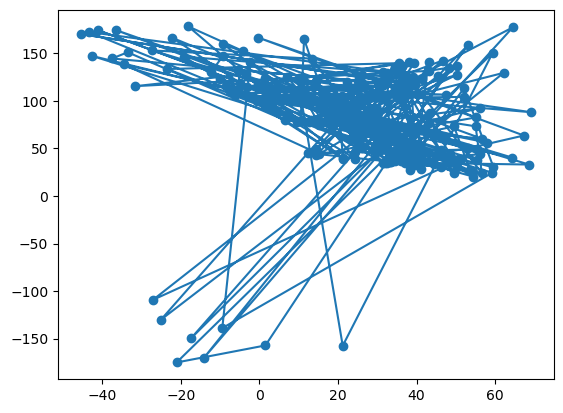

Generation: 1000 | Best Fitness Value: 2259.4349999999986


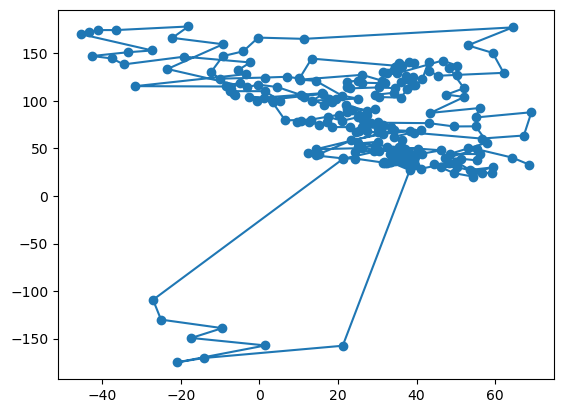

Generation: 2000 | Best Fitness Value: 2024.466999999999


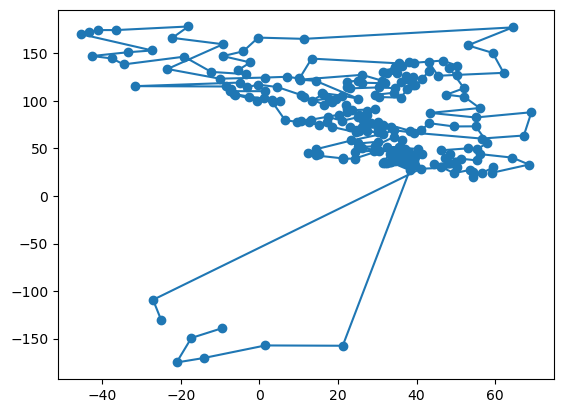

Generation: 3000 | Best Fitness Value: 1949.8139999999987


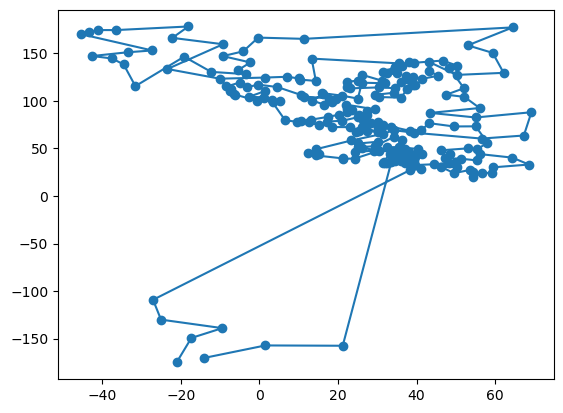

Generation: 4000 | Best Fitness Value: 1906.907999999999


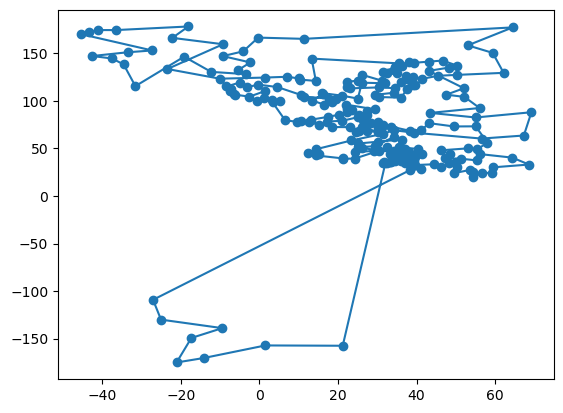

Generation: 5000 | Best Fitness Value: 1889.7029999999986


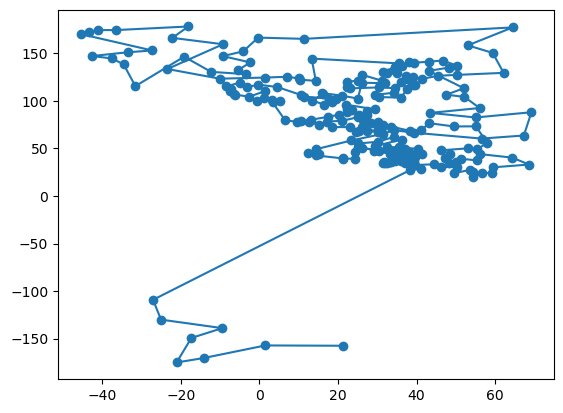

In [504]:
res_gr, recorder_gr, tm_gr = mainGA(5000, 0.25, 0.9)

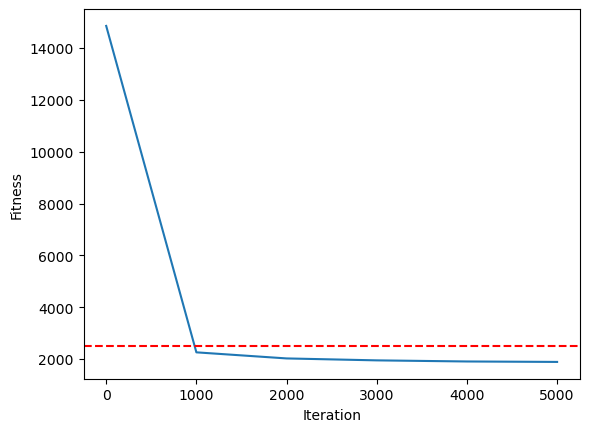

In [505]:
plt.plot(tm_gr, recorder_gr)
plt.axhline(y = 2500, color='red', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

### pr1002

- After fine-tuning the mutation and crossover rate parameters through numerous runs, a fitness value of 855,497.268 was attained following 5000 iterations and the designated threshold fitness value of 1e6 was reached around the 3000th iteration. 
- Observing the trend in the fitness plot, which has not plateaued, suggests that extending the number of iterations could yield further improvements in the algorithm’s performance. 
- A significant consideration is the time investment, as completing 5000 iterations required approximately 2 hours.

Generation: 0 | Best Fitness Value: 6158656.5969999945


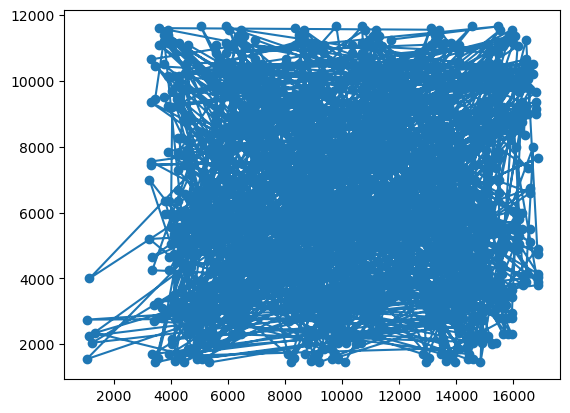

Generation: 1000 | Best Fitness Value: 1746271.9989999987


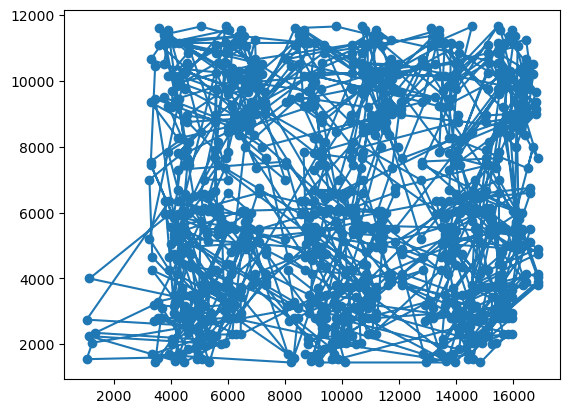

Generation: 2000 | Best Fitness Value: 1267033.1169999978


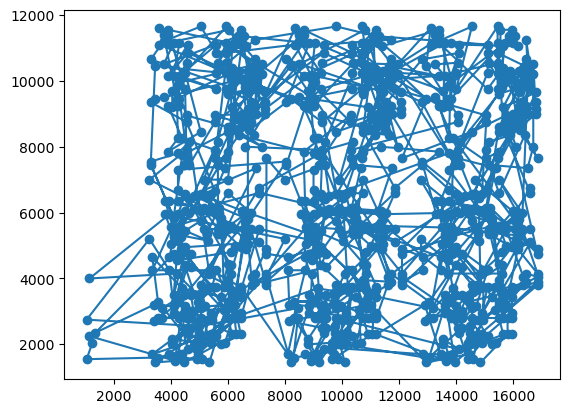

Generation: 3000 | Best Fitness Value: 1046722.0799999989


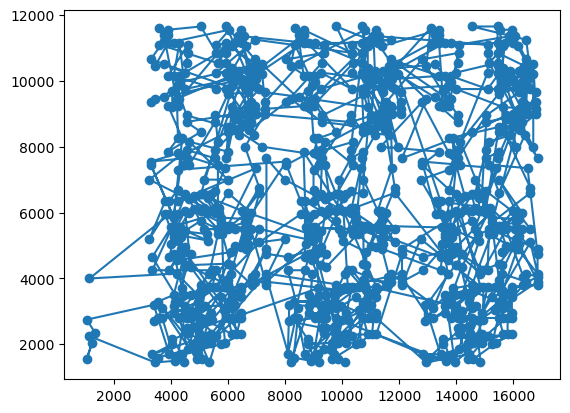

Generation: 4000 | Best Fitness Value: 927767.5880000002


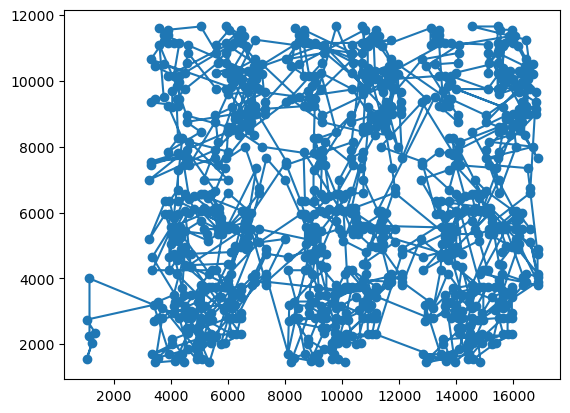

Generation: 5000 | Best Fitness Value: 855497.2679999981


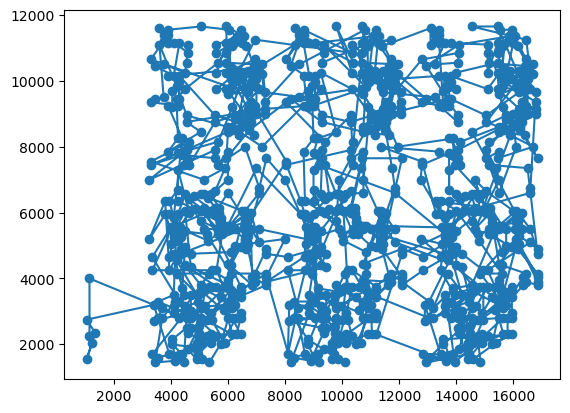

In [495]:
res_pr, recorder_pr, tm_pr = mainGA(5000, 0.2, 0.9)

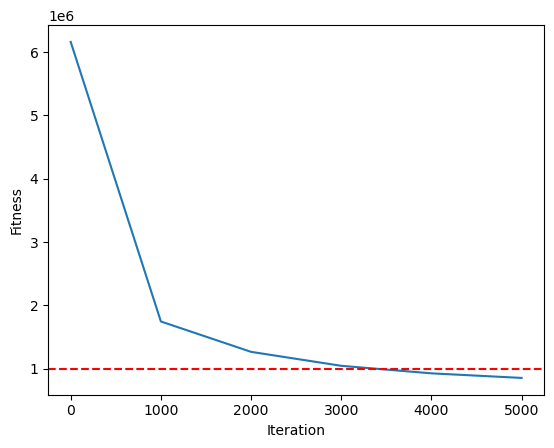

In [497]:
plt.plot(tm_pr, recorder_pr)
plt.axhline(y = 1e6, color='red', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()